* Goals for today
    * I assume familiarity with QICK (that's why we're here)
    * But let's spend some time to understand what goes on under the hood, so you can better understand what QICK does
    * phase coherence?
    * IQ mixing?
    * nyquist modes?
    * phase shift correction?

* Goals for today
    * QICK: pulse generation and readout for qubits - link to Alex and Sara’s presentations
    * Up- and down-conversion
    * Mixers (RF board, but can also be discrete)
* Out of scope for today
    * Other RFSoC applications
        * CW measurement: MKIDs, BREAD
        * Full-speed (not downconverted) readout
    * Details
        * Feedback (see demos!)
        * Other gens and ROs: multiplexing, interpolation (ask us!)
        * Safe programming: timing, frequency matching, time units (see docs!)
* What is the RFSoC?
    * High-speed DAC and ADC
    * FPGA
    * CPU
    * Off-the-shelf eval boards
* What is QICK?
    * Firmware (standard firmware + on request)
    * Software library
    * Documentation (demos + docs)
* Connecting to rfsoc
    * It’s a Raspberry Pi
    * Local notebook, or Pyro (or cloud?)
* Initial setup of rfsoc
    * SD image
    * Network - talk to me if you're putting one on the Fermilab network
    * QICK repo (includes library + standard firmware) https://github.com/openquantumhardware/qick
* How to approach the QICK
    * It's easy to play around - it costs you very little to just try something in a notebook
        * We can provide remote access to a shared board
    * Dig deep - you can see and modify all the (Python) backend code, and even the firmware

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from matplotlib import colors
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


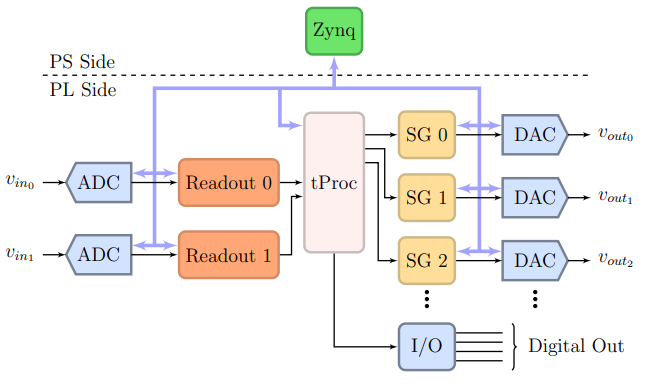

In [2]:
soc = QickSoc()
soccfg = soc
print(soccfg)

resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6

In [3]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_chs'][0])

    for ii, iq in enumerate(iq_list):
        plot = axs[ii]
        if plot_iq:
            plot.plot(t, iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
            plot.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
            plot.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
        else:
            plot.plot(t, iq[0], label="input value, ADC %d"%(config['ro_chs'][ii]))
        plot.set_ylabel("a.u.")
        plot.set_xlabel("Time [us]")
        plot.set_title("Averages = " + str(config["soft_avgs"]))
        plot.legend()
        
def plot_accumulated(iq_list, d_buf, prog, config, span=100):
    fig, axs = plt.subplots(2,1,figsize=(10,10))
    iqs = np.array(iq_list)[:,:,0].T

    for ii, (iq, buf, ch) in enumerate(zip(iqs, d_buf, prog.ro_chs)):
        plot = axs[ii]
        nsamp = prog.ro_chs[ch]['length']
        center = iq*nsamp
        hrange = [[center[0]-span, center[0]+span],[center[1]-span, center[1]+span]]
        plot.hist2d(buf[:,0], buf[:,1], bins=100, range=hrange, norm=colors.LogNorm())
        plot.set_xlabel("I value, ADC %d"%(config['ro_chs'][ii]))
        plot.set_ylabel("Q value, ADC %d"%(config['ro_chs'][ii]))
        
def noise(prog):
    diq = (prog.di_buf+1j*prog.dq_buf)/next(iter(prog.ro_chs.values()))['length']
    dmean = np.mean(diq,axis=1)
    dmag = np.abs(dmean)
    drotated = diq*np.exp(-1j*np.angle(dmean))[:,np.newaxis]
    drmsmag = np.std(np.real(drotated),axis=1) # noise in the radial direction
    drmsrot = np.std(np.imag(drotated), axis=1) # noise in the azimuth direction
    return drmsmag, drmsrot

### an example program

In [4]:
class FSGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'][iCh], ro_ch=cfg["ro_chs"][0])
            
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg['pulse_freq'],gen_ch=ch,ro_ch=cfg["ro_chs"][0]),
                         gain=cfg['pulse_gain'],
                         phase=0)

            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'product',
    'style': 'arb',
    'pulse_gain': 30000,    # a.u.
    'pulse_freq': 80,       # MHz
    'adc_trig_offset': 0.4, # us
    'length': 0.3,          # us
    'readout_padding': 0.1, # us
    'relax_delay': 2,       # us
    'reps': 1,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
print(prog)


// Program

        regwi 3, $11, 49932190;                 //freq = 49932190
        regwi 3, $12, 0;                        //phase = 0
        regwi 3, $14, 30000;                    //gain = 30000
        regwi 3, $13, 0;                        //addr = 0
        regwi 3, $15, 524417;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 129 
        regwi 4, $11, 49932190;                 //freq = 49932190
        regwi 4, $12, 0;                        //phase = 0
        regwi 4, $14, 30000;                    //gain = 30000
        regwi 4, $13, 0;                        //addr = 0
        regwi 4, $15, 524417;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 129 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $31, 49153;                    //out = 0b1100000000000001
        seti 0, 0, $31, 172;                    //ch =0 out = $31 @t = 0
        seti 0, 0, $0, 182;                     //ch =0 

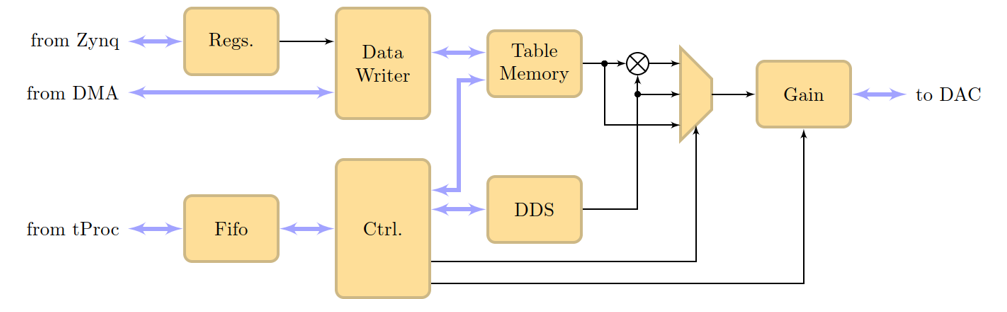

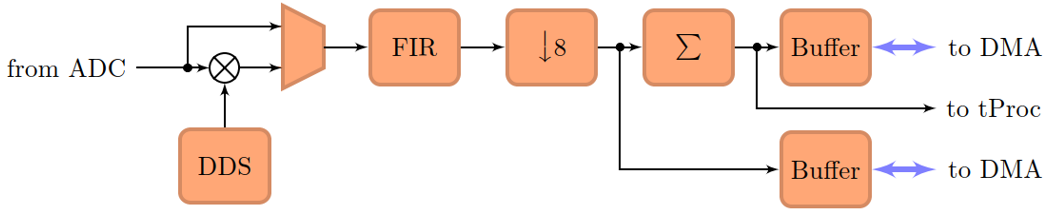

### let's look at low-frequency pulses with direct readout and on the scope

  0%|          | 0/1 [00:00<?, ?it/s]

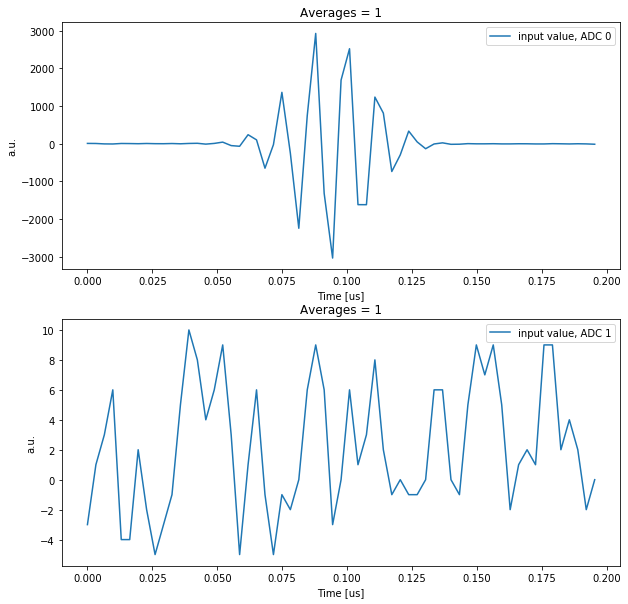

In [9]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'input',
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 30000,
    'pulse_freq': 80,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1,
    'soft_avgs': 1
#     'soft_avgs': 100
}
prog = FSGenLoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=False)

### let's look at pulses with downconverted readout, and go to higher frequency
phase coherence!

  0%|          | 0/1000 [00:00<?, ?it/s]

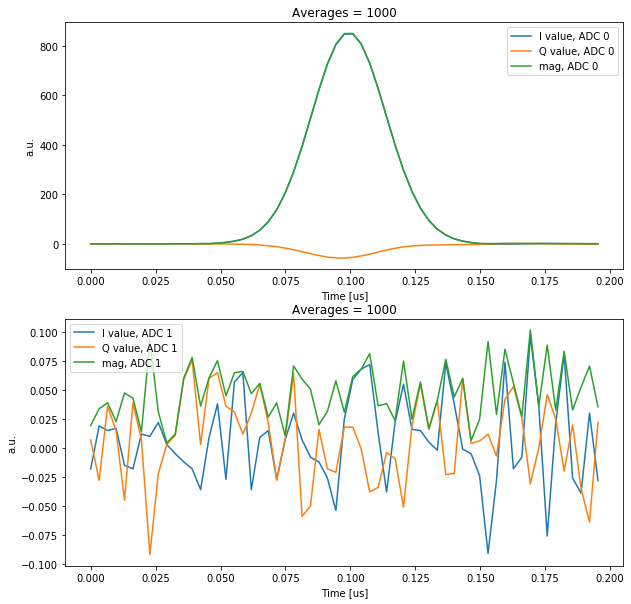

In [233]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'ro_sel': 'product',
    'nqz': [1,1],
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 32000,
#     'pulse_freq': 80,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1,
#     'soft_avgs': 1
    'soft_avgs': 1000
}
prog = FSGenLoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

### let's switch to accumulated readout
much faster!

  0%|          | 0/100000 [00:00<?, ?it/s]

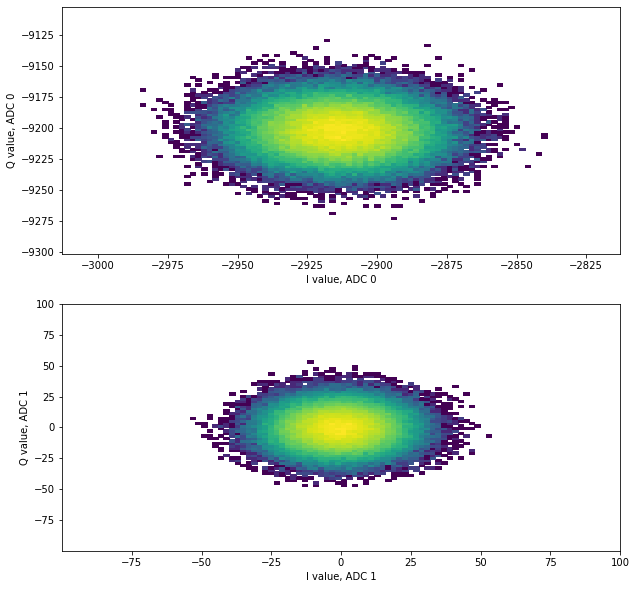

In [11]:
config = {
    'gen_chs': [4,6],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'product',
#     'style': 'const',
    'style': 'arb',
    'pulse_gain': 32000,
#     'pulse_freq': 80,
    'pulse_freq': 800,
    'adc_trig_offset': 0.4,
    'length': 0.1,
    'readout_padding': 0.1,
    'relax_delay': 2,
#     'reps': 1,
    'reps': 100000,
    'soft_avgs': 1
}
prog = FSGenLoopbackProgram(soccfg, config)
prog.acquire(soc, progress=False)
iq_list = prog.acquire(soc, progress=True)
d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)
# Plot results.
plot_accumulated(iq_list, d_buf, prog, config, span=100)

### go to high frequency (with appropriate baluns), do a frequency sweep

  0%|          | 0/101 [00:00<?, ?it/s]

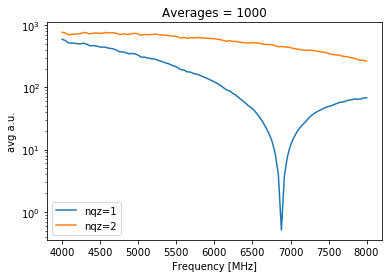

In [12]:
config = {
    'gen_chs': [0],
    'ro_chs': [1],
    'nqz': [2],
    'ro_sel': 'product',
    'style': 'const',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 1000,
    'soft_avgs': 1
}

freqs = np.linspace(start=4000, stop=8000, num=101)
means = np.zeros((len(freqs),2), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    for j, nqz in enumerate([1,2]):
        config['pulse_freq'] = f
        config['nqz'] = [nqz]

        prog = FSGenLoopbackProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        means[i,j] = np.array(res).T[0].dot([1,1j])

fig, axs = plt.subplots()
plot = axs
plot.semilogy(freqs, np.abs(means[:,0]), label="nqz=1")
plot.semilogy(freqs, np.abs(means[:,1]), label="nqz=2")
plot.set_ylabel("avg a.u.")
plot.set_xlabel("Frequency [MHz]")
plot.set_title("Averages = " + str(config["reps"]))
plot.legend()

Xilinx doc on DAC modes (nqz=1 is "normal" and should be used in 1st Nyquist zone, nqz=2 is "mix-mode" and should be used in 2nd and above): https://docs.xilinx.com/r/en-US/pg269-rf-data-converter/RF-DAC-Nyquist-Zone-Operation

This plot shows performance for an ideal infinite-bandwidth DAC. The gain fluctuation is just coming from the "zero-order hold" behavior of the DAC.

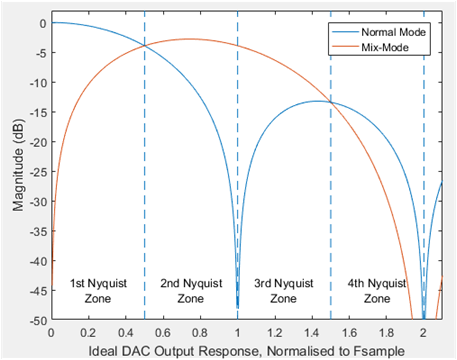

Note that the ADC is happily operating in 5th or 6th Nyquist zone.

### add a cavity

  0%|          | 0/101 [00:00<?, ?it/s]

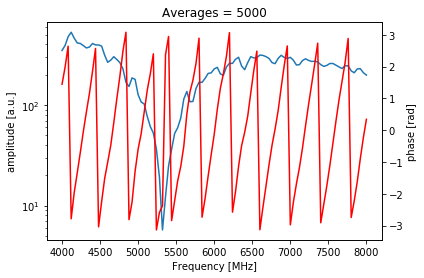

In [218]:
config = {
    'gen_chs': [4],
    'ro_chs': [1],
    'nqz': [2],
    'ro_sel': 'product',
    'style': 'const',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 5000,
    'soft_avgs': 1
}

freqs = soccfg.adcfreq(np.linspace(start=4000, stop=8000, num=101),
                       gen_ch=config['gen_chs'][0],
                       ro_ch=config['ro_chs'][0])
means = np.zeros((len(freqs),1), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    means[i] = np.array(res).T[0].dot([1,1j])

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(means[:,0]), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.angle(means[:,0]),color='red', label='phase')
plot.set_ylabel("amplitude [a.u.]")
ax2.set_ylabel("phase [rad]")

plot.set_xlabel("Frequency [MHz]")
plot.set_title("Averages = " + str(config["reps"]))

cavity_data = (freqs, means)

### calibrate the phase delay
What we're doing here is the same thing as in the "01_Phase_coherent_readout" demo (but simplified, and iterated to cover this large frequency range).

In [216]:
config = {
    'gen_chs': [4],
    'ro_chs': [1],
    'nqz': [2],
    'ro_sel': 'product',
    'style': 'const',
    'pulse_gain': 32000,
    'adc_trig_offset': 0.4,
    'length': 5,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 1000,
    'soft_avgs': 1
}

freqs = soccfg.adcfreq(np.linspace(start=4000, stop=4000.1, num=101))
means = np.zeros((len(freqs),1), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    means[i] = np.array(res).T[0].dot([1,1j])

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_correction = np.linalg.lstsq(a, np.unwrap(np.angle(means[:,0])), rcond=None)[0][0]/(2*np.pi)
print("first pass: delay %.4f us"%(phase_correction))

freqs = soccfg.adcfreq(np.linspace(start=4000, stop=4100, num=101))
means = np.zeros((len(freqs),1), dtype=complex)

for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
    
    prog = FSGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    means[i] = np.array(res).T[0].dot([1,1j])

means_rotated = means*np.exp(-1j*freqs[:,np.newaxis]*2*np.pi*phase_correction)

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_trim = np.linalg.lstsq(a, np.unwrap(np.angle(means_rotated[:,0])), rcond=None)[0][0]/(2*np.pi)
phase_correction += phase_trim
print("second pass: trim %.4f us, total delay %.4f us"%(phase_trim, phase_correction))

  0%|          | 0/101 [00:00<?, ?it/s]

first pass: delay 161.6552 us


  0%|          | 0/101 [00:00<?, ?it/s]

second pass: trim -0.0777 us, total delay 161.5774 us


### apply the phase correction

Text(0.5, 1.0, 'Averages = 1000')

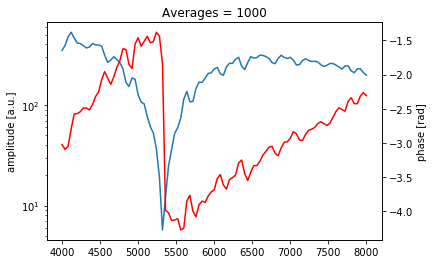

In [217]:
freqs, means = cavity_data
means_rotated = means*np.exp(-1j*freqs[:,np.newaxis]*2*np.pi*phase_correction)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(means_rotated[:,0]), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.unwrap(np.angle(means_rotated[:,0])),color='red', label='phase')
plot.set_ylabel("amplitude [a.u.]")
ax2.set_ylabel("phase [rad]")
plot.set_title("Averages = " + str(config["reps"]))

### phase reset (advanced - you should probably talk to us!)
Normally the generator and readout oscillators are phase-coherent (they maintain the same phase, between shots and runs). 
* This is what you want for reading out resonators (you want the DAC and ADC to maintain constant relative phase)
* This is also what you want for a qubit drive (when you play a sequence of gates at the resonant frequency, each gate should have the correct phase relative to the qubit's internal phase)

But you might need to play two gates (to drive a coupler, a different resonance, etc.) that have different frequencies, but need a fixed relationship both in time and in phase. This is impossible in the above picture - if you imagine two free-running oscillators at different frequencies, their phase angle will rotate at the difference frequency.

The solution is to reset the generator oscillator phases at the start of each shot.

If you need to do a phase reset on a readout tone, you will also need to do a phase reset on the readout oscillator. This requires a special firmware and changes to your program.

In [317]:
class PhrstProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        for iCh, ch in enumerate(cfg["gen_chs"]):  # configure the pulse lengths and upconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'][iCh], ro_ch=cfg["ro_chs"][0])
            
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg['pulse_freq'][iCh],gen_ch=ch,ro_ch=cfg["ro_chs"][0]),
                         gain=cfg['pulse_gain'],
                         phase=0,
                         phrst=cfg['phrst'])

            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            length_ro = self.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"][iCh],
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_chs"][0])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_chs"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config = {
    'gen_chs': [6,4],
    'ro_chs': [0,1],
    'nqz': [1,1],
    'ro_sel': 'product',
    'style': 'const',
#     'phrst': 0,
    'phrst': 1,
    'pulse_gain': 30000,    # a.u.
    'pulse_freq': [80,100],       # MHz
    'adc_trig_offset': 0.4, # us
    'length': 0.2,          # us
    'readout_padding': 0.1, # us
    'relax_delay': 2,       # us
    'reps': 1,
    'soft_avgs': 1
#     'soft_avgs': 100
}
prog = PhrstProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
# plot_decimated(iq_list, soccfg, config, plot_iq=True)

  0%|          | 0/1 [00:00<?, ?it/s]